In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import joblib


In [ ]:
# Load each dataset (adjust the paths to your local machine if needed)
stock_df = pd.read_csv("data/stock_data.csv")
hatch_df = pd.read_csv("data/hatch_data.csv")
dai_df = pd.read_csv("data/dai_data.csv")

# Preview the data
print(stock_df.head())
print(hatch_df.head())
print(dai_df.head())

# Check columns in dai_df
print("Columns in dai_df:", dai_df.columns)

# Ensure 'Year' column exists in dai_df
if 'Year' not in dai_df.columns:
    raise KeyError("'Year' column is missing in dai_df. Please check the dataset.")

# Convert 'Year' to numeric
dai_df['Year'] = pd.to_numeric(dai_df['Year'], errors='coerce')

# Make sure 'Year' is numeric
hatch_df['Year'] = pd.to_numeric(hatch_df['Year'], errors='coerce')
dai_df['Year'] = pd.to_numeric(dai_df['Year'], errors='coerce')

# Check columns in hatch_df
print("Columns in hatch_df:", hatch_df.columns)

# Check columns in dai_df
print("Columns in dai_df:", dai_df.columns)

# Ensure 'Region' column is of the same type in both DataFrames
hatch_df['Region'] = hatch_df['Region'].astype(str)
dai_df['Region'] = dai_df['Region'].astype(str)


In [35]:
import pandas as pd

# Reload the DAI dataset (cleaned and correct)
dai_df = pd.read_csv("data/dai_data.csv")

# Step 1: Calculate adoption growth by region over time
dai_df = dai_df.sort_values(by=["Region", "Year"])
dai_df["Adoption_Growth"] = dai_df.groupby("Region")["Digital Adoption Index"].pct_change().fillna(0)

# Step 2: Create High Demand label based on median growth
threshold = dai_df["Adoption_Growth"].median()
dai_df["High_Demand"] = (dai_df["Adoption_Growth"] > threshold).astype(int)

# Output structure check
dai_df.shape, dai_df.columns, dai_df.head()


C:\Users\timmy\AppData\Local\Temp\ipykernel_41896\1949837850.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  dai_df["Adoption_Growth"] = dai_df.groupby("Region")["Digital Adoption Index"].pct_change().fillna(0)


((366, 8),
 Index(['Region', 'Year', 'Digital Adoption Index', 'DAI Business Sub-index',
        'DAI People Sub-index', 'DAI Government Sub-index', 'Adoption_Growth',
        'High_Demand'],
       dtype='object'),
         Region  Year  Digital Adoption Index  DAI Business Sub-index  \
 0  Afghanistan  2014                0.302608                0.296788   
 1  Afghanistan  2016                0.343214                0.341886   
 2      Albania  2014                0.543884                0.554248   
 3      Albania  2016                0.607904                0.621125   
 4      Algeria  2014                0.369554                0.449673   
 
    DAI People Sub-index  DAI Government Sub-index  Adoption_Growth  \
 0              0.087707                  0.523330         0.000000   
 1              0.123343                  0.564413         0.134187   
 2              0.387060                  0.690344         0.000000   
 3              0.463779                  0.738807         0

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Features and Target
features = ['Digital Adoption Index', 'DAI Business Sub-index',
            'DAI People Sub-index', 'DAI Government Sub-index', 'Adoption_Growth']
X = dai_df[features]
y = dai_df['High_Demand']

# 2. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 5. Evaluation
y_pred = model.predict(X_test_scaled)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[40  0]
 [ 0 34]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        34

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74



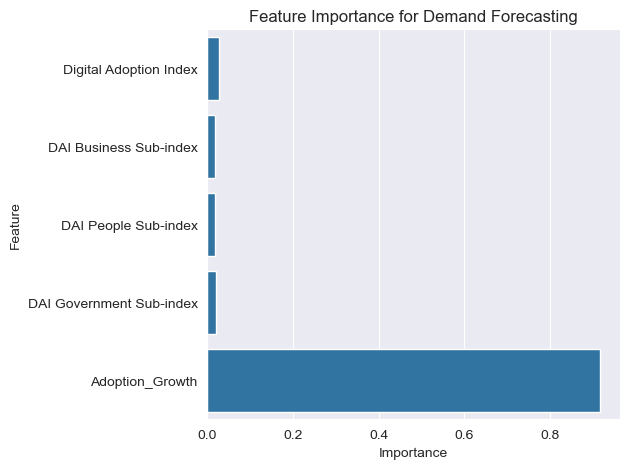

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance
importances = model.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance for Demand Forecasting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [38]:
# Simulation of a new region's future DAI values
future_data = pd.DataFrame([{
    'Digital Adoption Index': 0.68,
    'DAI Business Sub-index': 0.7,
    'DAI People Sub-index': 0.65,
    'DAI Government Sub-index': 0.75,
    'Adoption_Growth': 0.12
}])

# Scale & predict
future_scaled = scaler.transform(future_data)
future_demand_pred = model.predict(future_scaled)
print("Predicted Demand Level:", 'High' if future_demand_pred[0] == 1 else 'Low')


Predicted Demand Level: High


In [39]:
import joblib
joblib.dump(model, 'models/demand_forecasting_model.pkl')
joblib.dump(scaler, 'models/dai_scaler.pkl')


['dai_scaler.pkl']

In [45]:
from sklearn.preprocessing import StandardScaler

# Assuming you already have 'dai_df' as your data and 'X' as your features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X would be your feature set

# Add predictions to your data
dai_df['Predicted_Demand'] = model.predict(X_scaled)

# Export to Excel
dai_df.to_excel("forecasted_demand_output.xlsx", index=False)


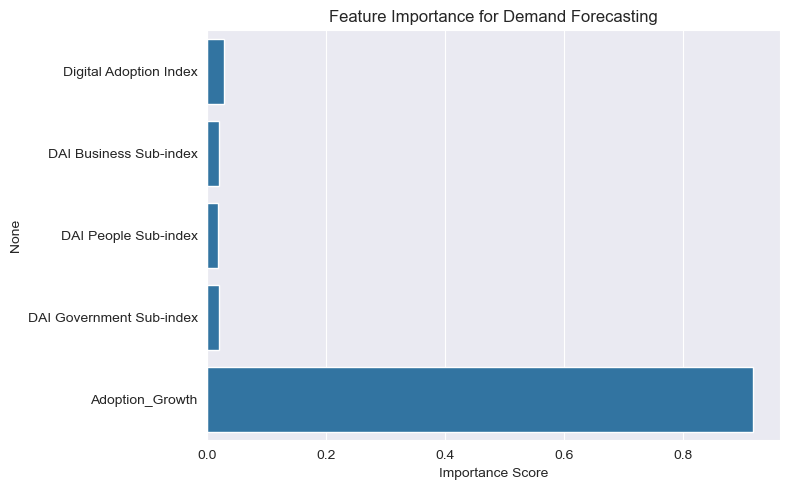

In [41]:
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance for Demand Forecasting")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()
